In [1]:
import sys
# Insert base project path here, like:
sys.path.append("../../")


import random

import numpy as np
import matplotlib.pyplot as plt

from src.utils import *
from src.LS.utils import *

random.seed(42) # Needed for reproducibility

# Scaling test

In [2]:
starting_m = 1000
last_m = 10000
n = 100
step = 1000
repeat = 5
time_qr_np, time_qr_a3, time_ls_np, time_ls_a3 = scaling(starting_m, last_m, n, step, repeat, False)

n=100, m=10000, t=5
m        QR A3      delta      QR np      delta      LS A3      delta      LS np      delta     
----------------------------------------------------------------------------------------------------
1000   ||  71.5728 |  71.5728 |  28.6996 |  28.6996 |  43.5858 |  43.5858 |  22.9678 |  22.9678
2000   || 108.9112 |  37.3384 |  32.3626 |   3.6630 |  76.2022 |  32.6164 |  23.7242 |   0.7564
3000   || 146.5482 |  37.6370 |  35.7730 |   3.4104 |  97.8836 |  21.6814 |  24.7996 |   1.0754
4000   || 179.3954 |  32.8472 |  38.9512 |   3.1782 | 117.4356 |  19.5520 |  26.4000 |   1.6004
5000   || 209.2108 |  29.8154 |  42.5788 |   3.6276 | 137.2184 |  19.7828 |  27.4042 |   1.0042
6000   || 244.7322 |  35.5214 |  46.3646 |   3.7858 | 170.0952 |  32.8768 |  29.3378 |   1.9336
7000   || 279.4732 |  34.7410 |  49.4526 |   3.0880 | 186.1066 |  16.0114 |  30.7878 |   1.4500
8000   || 318.3740 |  38.9008 |  53.1472 |   3.6946 | 218.5202 |  32.4136 |  31.3240 |   0.5362
9000   || 353.

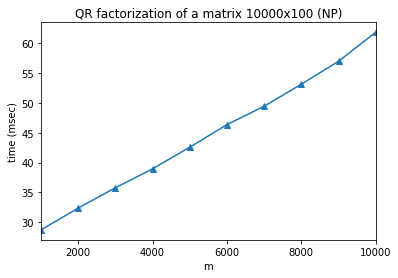

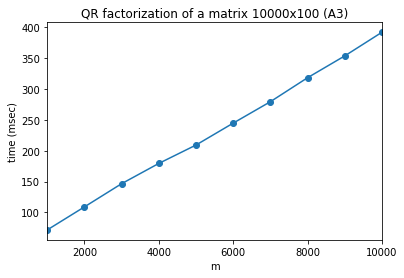

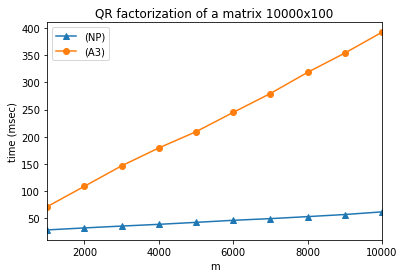

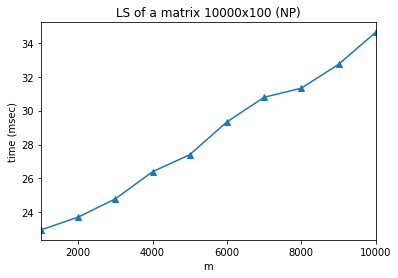

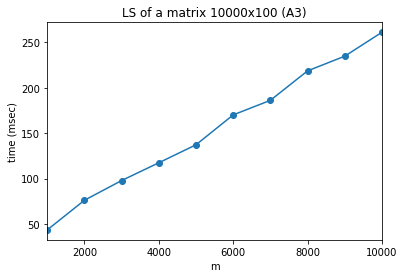

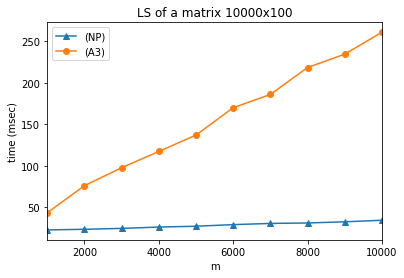

<Figure size 432x288 with 0 Axes>

In [3]:
plot_stats(time_qr_np, time_qr_a3, time_ls_np, time_ls_a3, range(starting_m, last_m + step, step), n, save=False)

In [2]:
starting_m = 10000
last_m = 50000
n = 100
step = 10000
repeat = 5
time_qr_np, time_qr_a3, time_ls_np, time_ls_a3 = scaling(starting_m, last_m, n, step, repeat, False)

n=100, m=50000, t=5
m        QR A3      delta      QR np      delta      LS A3      delta      LS np      delta     
----------------------------------------------------------------------------------------------------
10000  || 403.7830 | 403.7830 |  65.4286 |  65.4286 | 269.7886 | 269.7886 |  35.5990 |  35.5990
20000  || 2217.7802 | 1813.9972 | 138.3306 |  72.9020 | 592.5708 | 322.7822 |  67.9486 |  32.3496
30000  || 2540.2494 | 322.4692 | 248.8810 | 110.5504 | 839.5812 | 247.0104 | 120.0948 |  52.1462
40000  || 2890.8716 | 350.6222 | 379.1234 | 130.2424 | 1118.7852 | 279.2040 | 173.0306 |  52.9358
50000  || 3246.4468 | 355.5752 | 501.7690 | 122.6456 | 1413.3038 | 294.5186 | 234.7914 |  61.7608

m        residual A3              residual np              reconstruct a3           reconstruct np          
----------------------------------------------------------------------------------------------------
10000  ||     0.9951607539143076 |     0.9951607539143076 | 1.1463173842825262e-15 |

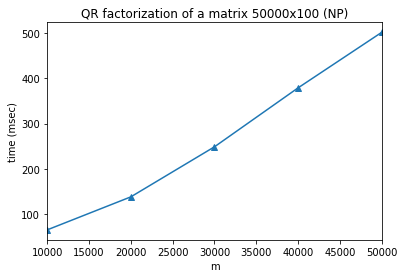

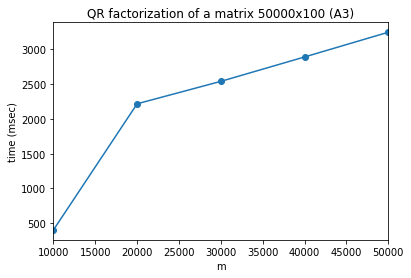

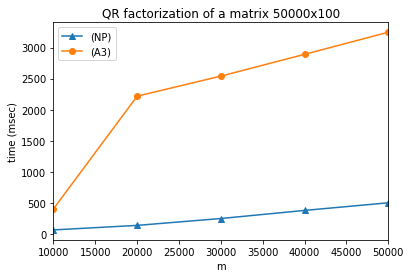

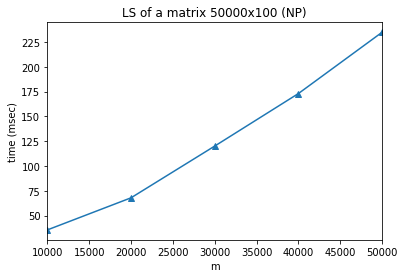

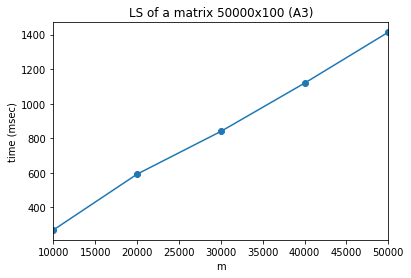

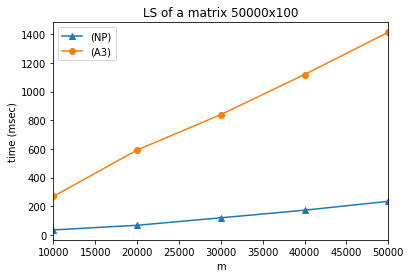

<Figure size 432x288 with 0 Axes>

In [3]:
plot_stats(time_qr_np, time_qr_a3, time_ls_np, time_ls_a3, range(starting_m, last_m + step, step), n, save=False)

# CUP test

The original CUP dataset with the provided dependent variable vector b, is far from being a linear problem. This can be seen by trying to solver the original CUP problem and comparing the result obtained with a "toy" problem that is linear. So, we generate a linear dependence between the original CUP dataset and a new vector b to show this.

In [2]:
cup = '../../data/ML-CUP20-TR.csv'

In [3]:
test = 'CUP'
M, _, b, _ = load_CUP(cup, split=0)
sol = np.random.rand(10)
b_new = M@sol

res, resnp = generic_test(M, b, 'ORIGINAL CUP')
analizeCond(M, b, res, resnp)


res_new, resnp_new = generic_test(M, b_new, 'LINEAR CUP')
analizeCond(M, b_new, res_new, resnp_new, sol)

---------- ORIGINAL CUP DATASET ----------
Solved (m x n): (1524,10) in 1.599 msec, w/ np in 0.318 msec - Reverting and reconstruction: 2.118 msec, w/ np took: 1.009 msec
res error: 0.9589384066878516 - np_res error: 0.9589384066878516
QR error: 5.490051337365104e-16 - QR error w/ np: 2.8585698651084886e-16
Relative error on R: 3.7193062129335555e-16
Relative error on Q: 1.7110069742313776e-15
Relative error on QR: 6.1419620260893005e-16

Theta:             1.283235131286147
eta:               None
kappa:             6.503404407917797
cos(Theta):        0.2836144075659144
cond y w.r.t b:    3.5259139639004116
cond y w.r.t A:    22.930444414768846
cond x w.r.t. b:   None
cond x w.r.t. A:   None

|res - resnp|/|resnp|:  2.128400840496273e-15

---------- LINEAR CUP DATASET ----------
Solved (m x n): (1524,10) in 1.387 msec, w/ np in 0.292 msec - Reverting and reconstruction: 2.274 msec, w/ np took: 0.356 msec
res error: 3.771567498989354e-16 - np_res error: 5.206752580472908e-16
QR error:

# Known QR

This test is used to check if the provided QR implementation, both via implicit computation of the vector Q^T*b and both via explicit reconstruction of the matrix Q, are suitable methods to solve basic QR problems. We generate a matrix A with a known QR factorization and we proceed by solving the QR factorization starting from A and comparing the matrix Q1 and R1 with the correct ones. We can see that even if Q1 and R1 are poor representations of the original matrices, we have that the reconstructed A is still a good representation of the original matrix. This is due to the backward stability of the QR factorization algorithm.

In [7]:
test = "Known QR"
m = 500
n = 500
M, _ = generate(m, n)
C, _ = generate(m, n)
Q, _ = np.linalg.qr(C)
R = np.triu(M)

A = (Q.T)@R
x = np.random.rand(m)
b = A@x
res, resnp = generic_test(A, b, test)

ls = LS()
R2 = ls.qr(A)
Q2 = ls.revertQ()
Q3, R3 = np.linalg.qr(A)


analizeCond(A, b, res, resnp, x)

print(f"{'|Q - Q2|/|Q|:':<18} {np.linalg.norm(Q - Q2,2) / np.linalg.norm(Q, 2)}")
print(f"{'|R - R2|/|R|:':<18}{np.linalg.norm(R - R2,2) / np.linalg.norm(R, 2)}")
print(f"{'|Q - Q3|/|Q|:':<18}{np.linalg.norm(Q - Q3,2) / np.linalg.norm(Q, 2)}")
print(f"{'|R - R3|/|R|:':<18}{np.linalg.norm(Q - R3,2) / np.linalg.norm(R, 2)}")
print(f"{'|A - Q2R2|/|A|:':<18}{np.linalg.norm(Q2@R2 - A,2) / np.linalg.norm(A, 2)}")
print(f"{'|A - Q3R3|/|A|:':<18}{np.linalg.norm(Q3@R3 - A,2) / np.linalg.norm(A, 2)}")

---------- Known QR DATASET ----------
Solved (m x n): (500,500) in 308.041 msec, w/ np in 67.83 msec - Reverting and reconstruction: 1665.6390000000001 msec, w/ np took: 36.452 msec
res error: 0.827491325399897 - np_res error: 3.481732069224497e-15
QR error: 1.850400722549916e-15 - QR error w/ np: 1.124767312585225e-15
Relative error on R: 1.3384482172031849
Relative error on Q: 2.0
Relative error on QR: 2.0621981298988718e-15

Theta:             0.9746248814657565
eta:               1.7269302718453654
kappa:             2.0485457002910026e+17
cos(Theta):        0.5614785003790633
cond y w.r.t b:    1.7810120945412578
cond y w.r.t A:    3.648484668438766e+17
cond x w.r.t. b:   2.1126994690642973e+17
cond x w.r.t. A:   3.5813505262198437e+34

|x - ~x|/|x|:           5166802169865.232
|res - resnp|/|resnp|:  5062124057098.102
|Q - Q2|/|Q|:      1.9999999999999991
|R - R2|/|R|:     1.4642373884424074
|Q - Q3|/|Q|:     1.9999925470946192
|R - R3|/|R|:     1.0014427340922838
|A - Q2R2|/|A|

# Test Random Matrix (m >> n)

In [18]:
test = 'RANDOM'
m = 1500     # number of rows
n = 10      # number of cols
M, b = generate(m, n)
res, resnp = generic_test(M, b, test)

analizeCond(M, b, res, resnp)

ls = LS()
R = ls.qr(M)
Q = ls.revertQ()

sol_explicit = np.linalg.inv(R)@Q.T@b
sol_implicit = np.linalg.inv(R)@(ls.implicit_Qb(b)[:n])

print(M.shape, Q.shape, R.shape, b.shape, sol_explicit.shape, (M@sol_explicit).shape)
print(f"explicit: {np.linalg.norm(M@sol_explicit - b,2) / np.linalg.norm(b,2)}")
print(f"implicit: {np.linalg.norm(M@sol_implicit - b,2) / np.linalg.norm(b,2)}")
print(f"|Q.T@(Ax-b)|/|b|: {np.linalg.norm((Q.T).dot(M@sol_explicit) - Q.T.dot(b),2) / np.linalg.norm(b,2)}")

---------- RANDOM DATASET ----------
Solved (m x n): (1500,10) in 2.317 msec, w/ np in 0.347 msec - Reverting and reconstruction: 2.535 msec, w/ np took: 0.601 msec
res error: 0.9948288174388222 - np_res error: 0.9948288174388222
QR error: 6.5931796010959e-16 - QR error w/ np: 3.381181049031673e-16
Relative error on R: 2.774498638120138e-16
Relative error on Q: 6.571083889217518e-16
Relative error on QR: 7.278780126894536e-16

Theta:             1.4690550316175532
eta:               None
kappa:             1.1593243198397722
cos(Theta):        0.10156586037283649
cond y w.r.t b:    9.845828079722025
cond y w.r.t A:    11.414507941783068
cond x w.r.t. b:   None
cond x w.r.t. A:   None

|res - resnp|/|resnp|:  2.0160826735320795e-15

(1500, 10) (1500, 10) (10, 10) (1500, 1) (10, 1) (1500, 1)
explicit: 0.9948288174388222
implicit: 0.9948288174388222
|Q.T@(Ax-b)|/|b|: 9.522253085953562e-17
